In [176]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [178]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [179]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
train_images=[]
train_labels=[]
path = masks = r'/content/drive/MyDrive/Blade_Turbine_Set/'
filename ='_1_1940335.png'
for e,i in enumerate(os.listdir(path)):
    try:
        if i.startswith("erosion"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [180]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.layers import  Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

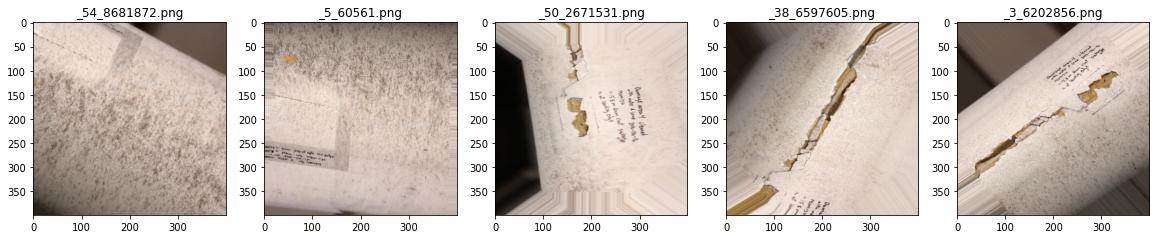

In [181]:
import random
plt.figure(figsize=(20,20))
img_folder=r'/content/drive/MyDrive/Blade_Turbine_Set/Edge_Area'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [182]:
damage_dir =r'/content/drive/MyDrive/Blade_Turbine_Set/Damage_Area'
erosion_dir =r'/content/drive/MyDrive/Blade_Turbine_Set/Erosion_Area'
edge_dir = r'/content/drive/MyDrive/Blade_Turbine_Set/Edge_Area'
reference_dir =r'/content/drive/MyDrive/Blade_Turbine_Set/Reference_Area'

In [183]:
print('total damaged images:', len(os.listdir(damage_dir)))
print('total erosion images:', len(os.listdir(erosion_dir)))
print('total edge area images:', len(os.listdir(edge_dir)))
print('total reference area images:', len(os.listdir(reference_dir)))


total damaged images: 192
total erosion images: 168
total edge area images: 72
total reference area images: 214


In [149]:
train_damage_names = os.listdir(damage_dir)
print(train_damage_names[:5])

train_erosion_names = os.listdir(erosion_dir)
print(train_erosion_names[:5])

train_edge_names = os.listdir(edge_dir)
print(train_edge_names[:5])

train_reference_names = os.listdir(reference_dir)
print(train_reference_names[:5])

['_7_6659643.png', '_14_517034.png', '_8_4166410.png', '_1_1940335.png', '_3_6344758.png']
['_16_2937492.png', '_12_2149596.png', '_1_8183550.png', '_2_7918213.png', '_25_8056084.png']
['_28_9347503.png', '_7_3212852.png', '_14_7505826.png', '_25_1717013.png', '_8_2966837.png']
['_13_7571898.png', '_10_779507.png', '_8_7701264.png', '_11_7641454.png', '_3_7352682.png']


Showing some damage pictures



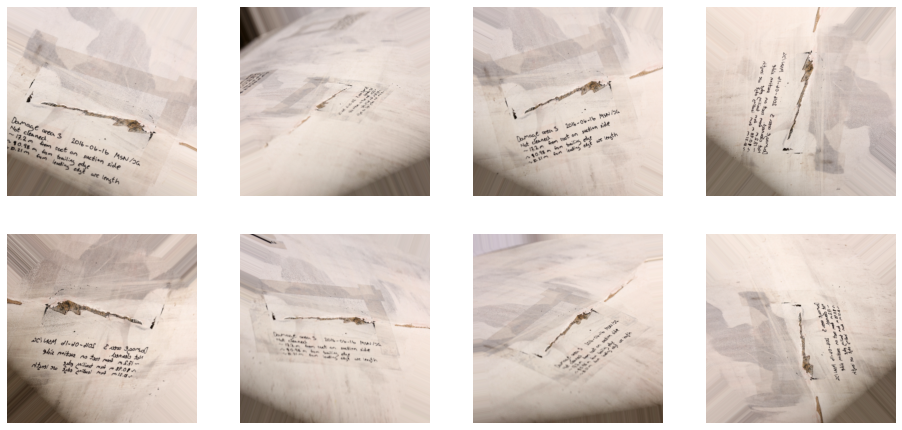

Showing some erosion pictures



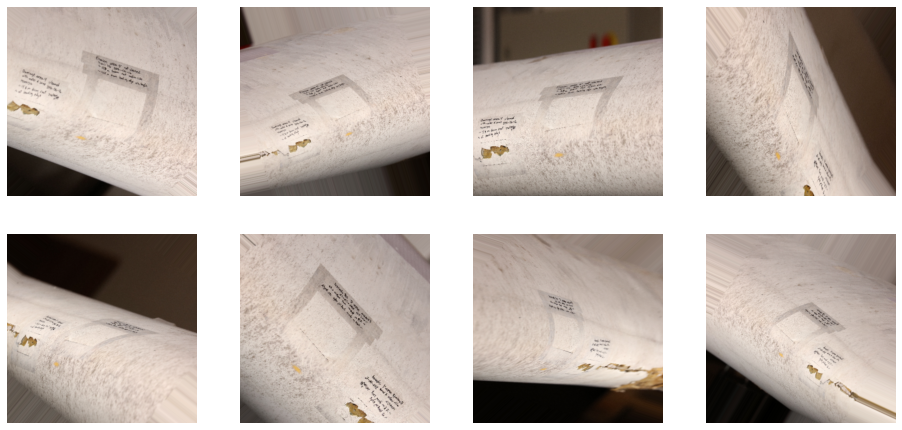

In [184]:
nrows = 4
ncols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_damage_pix = [os.path.join(damage_dir, fname) 
                for fname in train_damage_names[pic_index-8:pic_index]]
next_erosion_pix = [os.path.join(erosion_dir, fname) 
                for fname in train_erosion_names[pic_index-8:pic_index]]

print ("Showing some damage pictures")
print()
for i, img_path in enumerate(next_damage_pix):
 
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

print ("Showing some erosion pictures")
print()
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i, img_path in enumerate(next_erosion_pix):
  
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 

  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [185]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
batch_size = 646

dir = r'/content/drive/MyDrive/Blade_Turbine_Set'
train_generator = train_datagen.flow_from_directory(dir , 
        target_size=(320, 320),  
        batch_size=batch_size,
        classes = ['Damage_Area','Edge_Area','Erosion_Area','Reference_Area'],
        class_mode='categorical')

val_datagen = tf.keras.preprocessing.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=batch_size)

Found 646 images belonging to 4 classes.
Found 646 files belonging to 4 classes.
Using 129 files for validation.


In [186]:
img_w, img_h = 220, 220 

4 classes with 646 images in total


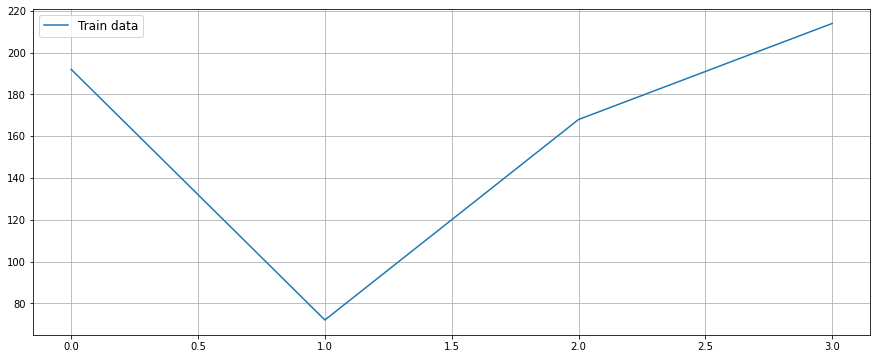

In [187]:
CLASSES, image = [], [] 
for root, dirs, files in os.walk(r'/content/drive/MyDrive/Blade_Turbine_Set'):
    f = os.path.basename(root)      
        
    if len(files) > 0:
        image.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) 
    
image_count = len(CLASSES) 
print('{} classes with {} images in total'.format(len(CLASSES), sum(image)))

f, ax = plt.subplots(figsize=(15,6))
if(image[0])<10:
    plt.plot(range(image_count ), image[image_count :], label = 'Train data')
    plt.plot(range(image_count ), image[0:image_count ], label = 'Test data')
else:
    plt.plot(range(image_count ), image[0:image_count ], label = 'Train data')
   
ax.grid()
ax.legend(fontsize = 12);

In [188]:
def read_imgs_lbls(dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(dir):
        f = os.path.basename(root)        
        for file in files:
            Labels.append(f)
            try:
                image1 = cv2.imread(root+'/'+file)             
                image1 = cv2.resize(image1,(int(img_w*1.5), int(img_h*1.5)))       
                image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                Images.append(image1)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [189]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):  
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [190]:
_dir = r'/content/drive/MyDrive/Blade_Turbine_Set'
Train_Imgs, Train_Lbls = read_imgs_lbls(_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (646, 330, 330, 3)
Shape of train labels: (646,)


In [191]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (516, 330, 330, 3), y_train: (516,) 
Shape of X_val: (130, 330, 330, 3), y_val: (130,) 


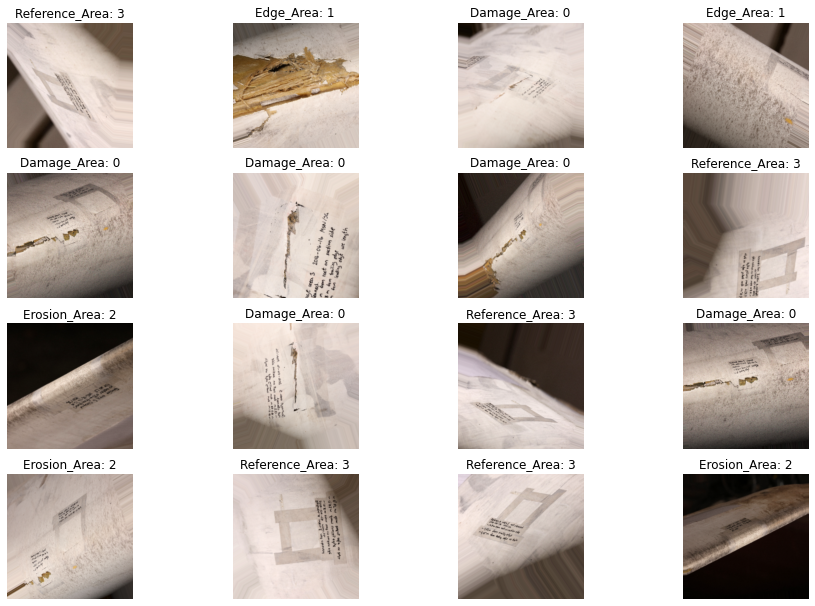

In [158]:
from random import randint
dim = 4

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

In [192]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]          
            new_img = cv2.resize(new_img,(img_w, img_h))  
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [193]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1           

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))    
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14) 

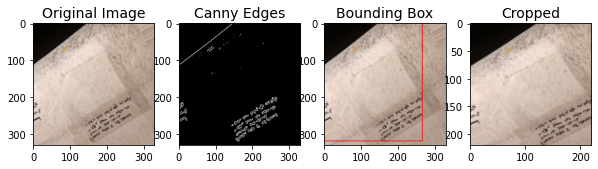

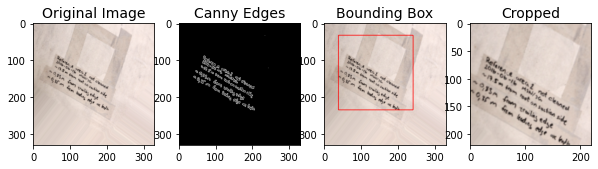

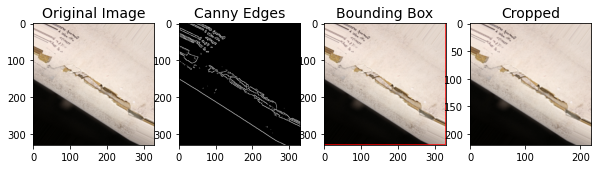

In [194]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

In [195]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [196]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (646, 220, 220, 3) 


In [197]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (516, 220, 220, 3), y_train: (516,) 
Shape of X_val: (130, 220, 220, 3), y_val: (130,) 


In [198]:
filters = 32      
kernel_size = 3   
max_pool = 3 

In [199]:
EPOCHS = 20                               
batch_size = 32                             
iter_per_epoch = len(X_train) // batch_size  
val_per_epoch = len(X_val) // batch_size 

In [200]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [201]:
from keras.layers import Dense
from keras import Model
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

In [202]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

model = Sequential()
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(MaxPooling2D((max_pool, max_pool))) 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))                                             # 512
model.add(Dense(87, activation='softmax'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 128)        

In [210]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'relu')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.summary()
model.compile(optimizer = "adam", 
             loss='categorical_crossentropy', 
              metrics = ['acc'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [203]:
model.compile(optimizer = "adam", 
             loss='sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [204]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(              
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()

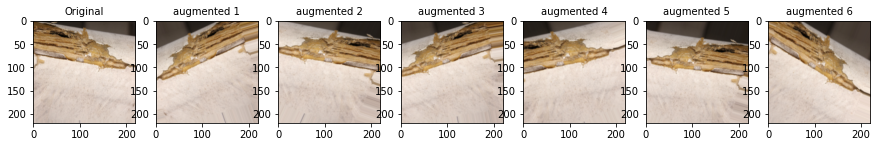

In [205]:
from random import randint
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=batch_size)
cols = 7
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

for i in range(1,cols):
    batch = it.next()    
    image = batch[0].astype('uint32') 
    ax[i].set_title('augmented {}'.format(i), fontsize=10)
    ax[i].imshow(image, cmap='gray')

In [206]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [207]:
history = model.fit_generator(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS, 
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose=1 
       )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
16/16 [==============================] - 31s 2s/step - loss: 8.1715 - acc: 0.2012 - val_loss: 1.2847 - val_acc: 0.3906
Epoch 2/20
16/16 [==============================] - 28s 2s/step - loss: 1.4844 - acc: 0.3175 - val_loss: 1.3088 - val_acc: 0.4297
Epoch 3/20
16/16 [==============================] - 28s 2s/step - loss: 1.3552 - acc: 0.3762 - val_loss: 1.2864 - val_acc: 0.3828
Epoch 4/20
16/16 [==============================] - 28s 2s/step - loss: 1.2766 - acc: 0.4031 - val_loss: 1.2673 - val_acc: 0.3594
Epoch 5/20
16/16 [==============================] - 28s 2s/step - loss: 1.4316 - acc: 0.3768 - val_loss: 1.2560 - val_acc: 0.5312
Epoch 6/20
16/16 [==============================] - 29s 2s/step - loss: 1.2710 - acc: 0.4443 - val_loss: 1.1877 - val_acc: 0.5547
Epoch 7/20
16/16 [==============================] - 29s 2s/step - loss: 1.1032 - acc: 0.5304 - val_loss: 1.2534 - val_acc: 0.4219
Epoch 8/20
16/16 [==============================] - 29s 2s/step - loss: 1.1573 - acc: 0.51

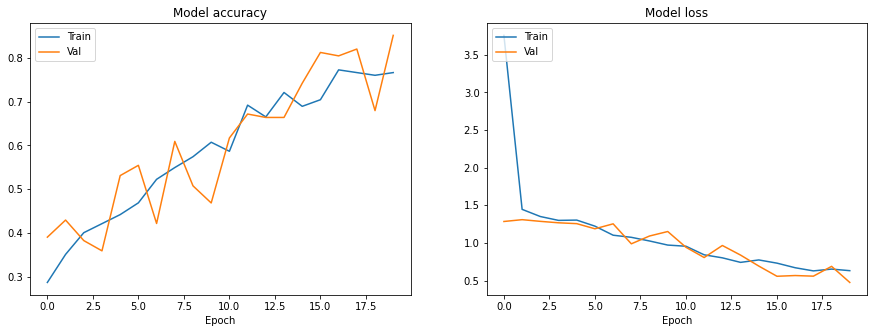

In [212]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].legend(['Train', 'Val'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].legend(['Train', 'Val'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

In [208]:
score = model.evaluate_generator(val_gen, steps= len(val_gen))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss:0.4690919518470764
acc:0.8538461327552795
